In [31]:
# experiment_names = ["dependent_var_nonlin_data_5_30_extrapolation_VAE", 
#                     "dependent_var_nonlin_data_5_30_extrapolation_cond_VAE",
#                    "dependent_var_nonlin_data_5_30_extrapolation_env_prior_VAE",
#                    "dependent_var_nonlin_data_5_30_extrapolation_env_trans_VAE"]
experiment_names = ["l1000_VAE", 
                    "l1000_cond_VAE",
                   "l1000_env_prior_VAE",
                   "l1000_env_trans_VAE"]

In [32]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.linalg import svd, inv
import pandas as pd
import matplotlib.pyplot as plt
import dill as pickle
import os
import pdb
import torch
import ai.causalcell
from ai.causalcell.training import set_seed, evaluate_epoch
from ai.causalcell.utils import configuration
os.chdir(os.path.join(os.path.dirname(ai.__file__), ".."))
print("Working in", os.getcwd())  

Working in /Users/paul/PycharmProjects/causal_cell_embedding


In [33]:
def load_all_losses(res, name='recon_loss'):
    all_train_loss = []
    for epoch in range(len(res['losses']['train'])):
        train_loss = np.mean([res['losses']['train'][epoch][i][name].detach().numpy() 
        for i in range(len(res['losses']['train'][epoch]))])
        all_train_loss.append(train_loss)
    all_valid_loss = []
    for epoch in range(len(res['losses']['valid'])):
        valid_loss = np.mean([res['losses']['valid'][epoch][i][name].numpy() 
        for i in range(len(res['losses']['valid'][epoch]))])
        all_valid_loss.append(valid_loss)
    return all_train_loss, all_valid_loss

In [34]:
def epoch_length(i):
    return results[i]['n_samples_in_split']['train']

In [35]:
def get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3):
    min_length = min(len(valid_loss1), len(valid_loss2), len(valid_loss3))
    concat_lists = np.array([valid_loss1[:min_length], valid_loss2[:min_length], valid_loss3[:min_length]])
    st_dev_list = np.std(concat_lists, 0)
    mean_list = np.mean(concat_lists, 0)
#     pdb.set_trace()
    return x_coord[:min_length], mean_list, st_dev_list

In [36]:
result_dir_list = []
for experiment_name in experiment_names:
    result_dir_list.append(os.path.join(os.getcwd(), "results", experiment_name))

In [37]:
results = []
for result_dir in result_dir_list:
    for exp_id in range(1, 4):
        with open(os.path.join(result_dir,'results_' 
                  + str(exp_id) + '.pkl'), 'rb') as f:
            results.append(pickle.load(f))

In [38]:
all_exp_losses = []
for exp_id in range(12):
    all_exp_losses.append(load_all_losses(results[exp_id]))

/Users/paul/miniconda3/envs/causalcell/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


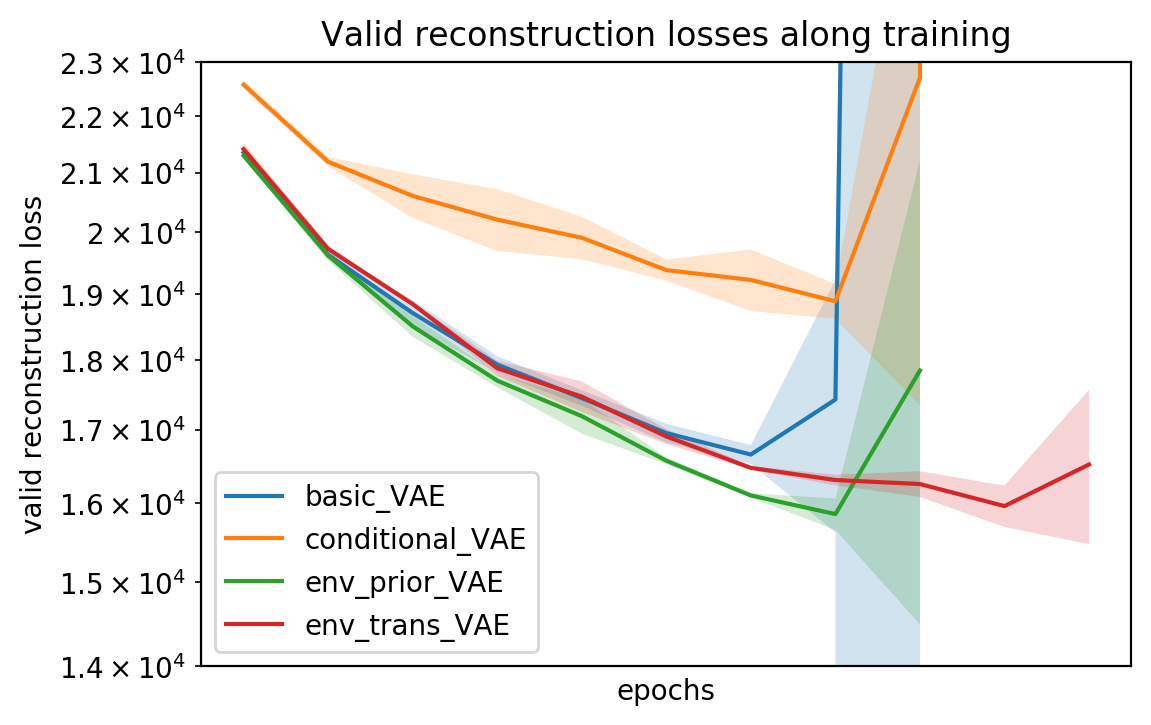

In [52]:
plt.figure(figsize=(6,4), dpi=200)
for exp_id in range(0, 12, 3):
    valid_loss1 = all_exp_losses[exp_id][1] #[:-3]
    valid_loss2 = all_exp_losses[exp_id + 1][1] #[:-3]
    valid_loss3 = all_exp_losses[exp_id + 2][1] #[:-3]
    x_coord =  [epoch_length(exp_id)*i for i in range(len(valid_loss1))]
    x_coord_tube, mean_list, st_dev_list = get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3)
    label = list(results[exp_id]['config']['model'].keys())[0]
    plt.fill_between(x_coord_tube, mean_list - st_dev_list, mean_list + st_dev_list, alpha=.2)
    plt.plot(x_coord_tube, mean_list, label=label)
plt.title("Valid reconstruction losses along training")
plt.yscale("log")
plt.ylim((14000, 23000))
plt.xticks([])
plt.xlabel("epochs")
plt.ylabel("valid reconstruction loss")
plt.legend(loc='lower left')
plt.show()

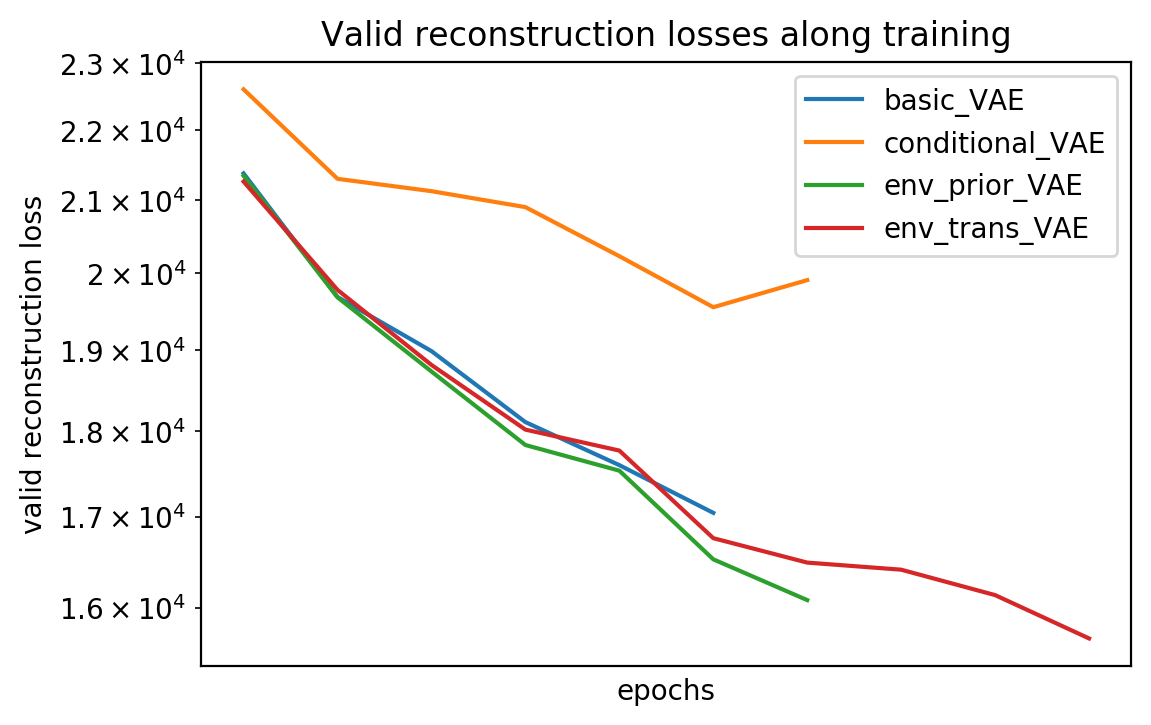

In [42]:
plt.figure(figsize=(6,4), dpi=200)
for exp_id in range(0, 12, 3):
    valid_loss1 = all_exp_losses[exp_id][1][:-5]
#     valid_loss2 = all_exp_losses[exp_id + 1][1]
#     valid_loss3 = all_exp_losses[exp_id + 2][1]
    x_coord =  [epoch_length(exp_id)*i for i in range(len(valid_loss1))]
#     x_coord_tube, mean_list, st_dev_list = get_tube(x_coord, valid_loss1, valid_loss2, valid_loss3)
    label = list(results[exp_id]['config']['model'].keys())[0]
#     plt.fill_between(x_coord_tube, mean_list - st_dev_list, mean_list + st_dev_list, alpha=.2)
    plt.plot(x_coord, valid_loss1, label=label)
plt.title("Valid reconstruction losses along training")
plt.yscale("log")
plt.xticks([])
plt.xlabel("epochs")
plt.ylabel("valid reconstruction loss")
plt.legend(loc='upper right')
plt.show()

In [11]:
set_seed(3)
valid_loader1 = configuration.setup_dataloader(results[0]['config'], 'valid') # trick to get new envs for test
valid_loader = configuration.setup_dataloader(results[0]['config'], 'valid')

pytorch/random seed: 3
global graph created with parameters (5, 30, 0.2, 'gn', 'noisy_lin_hidden_neural_net_obs_generator')
valid split of size 5000 with number of environments 5
global graph already instantiated
valid split of size 5000 with number of environments 5


RDKit WARNING: [18:18:13] Enabling RDKit 2019.09.3 jupyter extensions


In [14]:
all_test_losses = []
for i in range(len(result_dir_list)):
    for j in range(3):
        model = configuration.setup_model(results[3*i+j]['config'])
        model.load_state_dict(torch.load(os.path.join(result_dir_list[i], "best_model_" + str(j+1) + ".pth.tar")))
        test_loss, test_losses = evaluate_epoch(model=model, device='cpu', data_loader=valid_loader, epoch=0)
        all_test_losses.append([test_losses[k]['recon_loss'] for k in range(len(test_losses))])

epoch 0 Mean valid loss: 523.6758
epoch 0 Mean valid loss: 4444.7808
epoch 0 Mean valid loss: 4559.2119
epoch 0 Mean valid loss: 957.5179
epoch 0 Mean valid loss: 4684.1274
epoch 0 Mean valid loss: 5547.9351
epoch 0 Mean valid loss: 716.7234
epoch 0 Mean valid loss: 4821.8428
epoch 0 Mean valid loss: 5862.2754
epoch 0 Mean valid loss: 1283.2229
epoch 0 Mean valid loss: 5032.9873
epoch 0 Mean valid loss: 6259.8501
